# IMDb Rating Prediction

---

### Importação de bibliotecas básicas

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

### Adiciona raiz do projeto ao PYTHONPATH

In [2]:
from pathlib import Path
import sys

sys.path.append(str(Path.cwd().parent))

### Import das funções dos scripts específicos

In [3]:
from src.preprocess import basic_clean, generate_wordcloud_from_series, generate_wordclouds_by_category, REPORTS_DIR, add_log_transforms, build_preprocessor
from src.train import train_and_eval
from src.predict import predict_one

### Carregar dataset no pandas

In [4]:
df = pd.read_csv('../data/desafio_indicium_imdb.csv')

## 1. Análise Exploratória dos Dados (EDA)

### Dimensões do dataframe:

In [5]:
df.shape

(999, 16)

### Amostra dos 5 primeiros dados:

In [6]:
df.head()

Unnamed: 0                                   Series_Title Released_Year  \
0           1                                  The Godfather          1972   
1           2                                The Dark Knight          2008   
2           3                         The Godfather: Part II          1974   
3           4                                   12 Angry Men          1957   
4           5  The Lord of the Rings: The Return of the King          2003   

  Certificate  Runtime                     Genre  IMDB_Rating  \
0           A  175 min              Crime, Drama          9.2   
1          UA  152 min      Action, Crime, Drama          9.0   
2           A  202 min              Crime, Drama          9.0   
3           U   96 min              Crime, Drama          9.0   
4           U  201 min  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  When the menace known as the Joker wreaks havo...        84.0   
2  The early life and career of Vito Corleone in ...        90.0   
3  A jury holdout attempts to prevent a miscarria...        96.0   
4  Gandalf and Aragorn lead the World of Men agai...        94.0   

               Director           Star1            Star2          Star3  \
0  Francis Ford Coppola   Marlon Brando        Al Pacino     James Caan   
1     Christopher Nolan  Christian Bale     Heath Ledger  Aaron Eckhart   
2  Francis Ford Coppola       Al Pacino   Robert De Niro  Robert Duvall   
3          Sidney Lumet     Henry Fonda      Lee J. Cobb  Martin Balsam   
4         Peter Jackson     Elijah Wood  Viggo Mortensen   Ian McKellen   

           Star4  No_of_Votes        Gross  
0   Diane Keaton      1620367  134,966,411  
1  Michael Caine      2303232  534,858,444  
2   Diane Keaton      1129952   57,300,000  
3   John Fiedler       689845    4,360,000  
4  Orlando Bloom      1642758  377,845,905

### Visão geral sobre as colunas, incluindo o tipo, a quantidade de valores não-nulos e uso de memória:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


#### Isolando os valores faltantes de cada coluna:

In [8]:
df_isnull = df.isnull().sum().to_frame('Count missing values').reset_index().rename(columns={'index':'Column'})

df_isnull[df_isnull['Count missing values'] > 0]

Column  Count missing values
3   Certificate                   101
8    Meta_score                   157
15        Gross                   169

### Estatísticas descritivas para cada coluna numérica:

In [9]:
df.describe()

Unnamed: 0  IMDB_Rating  Meta_score   No_of_Votes
count  999.000000   999.000000  842.000000  9.990000e+02
mean   500.000000     7.947948   77.969121  2.716214e+05
std    288.530761     0.272290   12.383257  3.209126e+05
min      1.000000     7.600000   28.000000  2.508800e+04
25%    250.500000     7.700000   70.000000  5.547150e+04
50%    500.000000     7.900000   79.000000  1.383560e+05
75%    749.500000     8.100000   87.000000  3.731675e+05
max    999.000000     9.200000  100.000000  2.303232e+06

### Estatísticas descritivas para colunas não-numéricas:

In [10]:
df.describe(include=['object'])

Series_Title Released_Year Certificate  Runtime  Genre  \
count           999           999         898      999    999   
unique          998           100          16      140    202   
top        Drishyam          2014           U  130 min  Drama   
freq              2            32         234       23     84   

                                                 Overview          Director  \
count                                                 999               999   
unique                                                999               548   
top     An organized crime dynasty's aging patriarch t...  Alfred Hitchcock   
freq                                                    1                14   

            Star1        Star2         Star3          Star4      Gross  
count         999          999           999            999        830  
unique        659          840           890            938        822  
top     Tom Hanks  Emma Watson  Rupert Grint  Michael Caine  4,360,000  
freq           12            7             5              4          5

### Primeiras observações:

1. O Dataframe possui 999 linhas e 16 colunas em seu formato original – precisamos verificar e remover possíveis duplicatas;
2. A coluna ``"Unnamed: 0"`` é apenas um índice salvo no CSV e não apresenta nenhuma informação útil, portanto vai ser removida;
3. A coluna ``"Released_year"`` é do tipo object, mas deveria ser numérico (int), logo vai ser convertida;
4. ``"Certificate"``, que indica a classificação indicativa, tem 101 valores ausentes. Por se tratar de uma variável categórica e importante para caracterizar o público-alvo, os valores foram imputados como "Unknown", evitando perda de dados e mantendo consistência do modelo.
5. ``"Gross"``, o faturamento bruto, precisa ser convertido para numérico, atualmente está como object.
6. ``"Meta_score"`` tem 157 valores ausentes. Neste caso, como a sua distribuição é estável (média é aproximadamente 78 e a mediana é 79), optou-se por imputar o valor da média. Essa escolha preserva a variável sem introduzir viés relevante na predição.
7. ``"Gross"`` tem 169 valores ausentes – neste caso, a decisão foi remover as linhas correspondentes, já que o faturamento é uma métrica central e imputá-la poderia distorccer análises financeiras.
8. ``"Runtime"`` está como object, mas também pode ser convertida para inteiro.

Assim sendo, o script ``src/preprocess.py`` é o responsável por centralizar as funções de pré-processamento associadas a essas conclusões. Nele, está sendo feito o tratamento completo, desde a remoção de colunas desnecessárias, até imputação ou remoção de linhas faltantes, e conversão de valores em numéricos.

In [11]:
df_cleaned = basic_clean(df)

Conferindo o estado do dataframe pós-limpeza:

In [12]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 829 entries, 0 to 996
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Series_Title   829 non-null    object  
 1   Released_Year  829 non-null    float64 
 2   Certificate    829 non-null    category
 3   Runtime        829 non-null    Int64   
 4   Genre          829 non-null    object  
 5   IMDB_Rating    829 non-null    float64 
 6   Overview       829 non-null    object  
 7   Meta_score     829 non-null    float64 
 8   Director       829 non-null    object  
 9   Star1          829 non-null    object  
 10  Star2          829 non-null    object  
 11  Star3          829 non-null    object  
 12  Star4          829 non-null    object  
 13  No_of_Votes    829 non-null    int64   
 14  Gross          829 non-null    float64 
dtypes: Int64(1), category(1), float64(4), int64(1), object(8)
memory usage: 99.4+ KB


Tendo aplicado as limpezas necessárias, vamos partir para a EDA mais profunda no df_cleaned. 

### 1.1. Análise Exploratória dos Dados (EDA) - Pós Limpeza

---

### Gráficos de dispersão com linha de tendência:

#### 1. IMDB_Rating x Gross
**Hipótese 1:** Filmes melhor avaliados tendem a ter maior bilheteria?

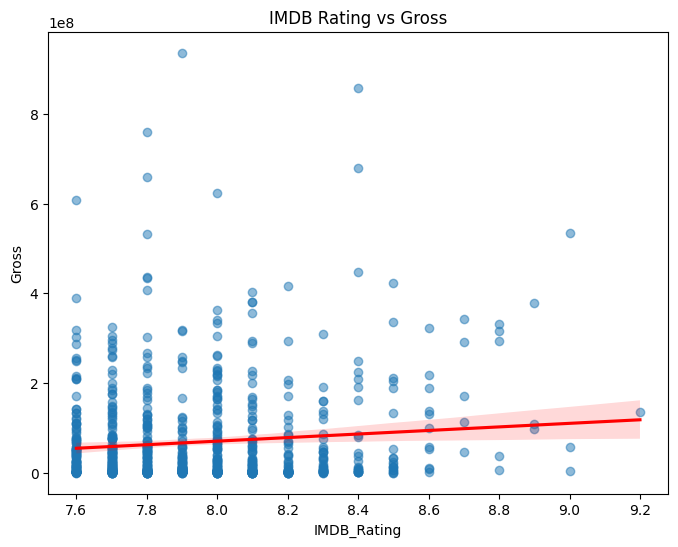

In [13]:
plt.figure(figsize=(8,6))
sns.regplot(x="IMDB_Rating", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("IMDB Rating vs Gross")
plt.show()


- **Tendência positiva fraca**: filmes com maior nota até arrecadam um pouco mais, mas a relação é quase nula;
- Existem vários filmes com notas boas, mas baixo faturamento. Isso significa que uma nota alta não garante sucesso comercial.

---

#### 2. Runtime x Gross
**Hipótese 2:** O tempo de duração do filme influencia no seu faturamento?

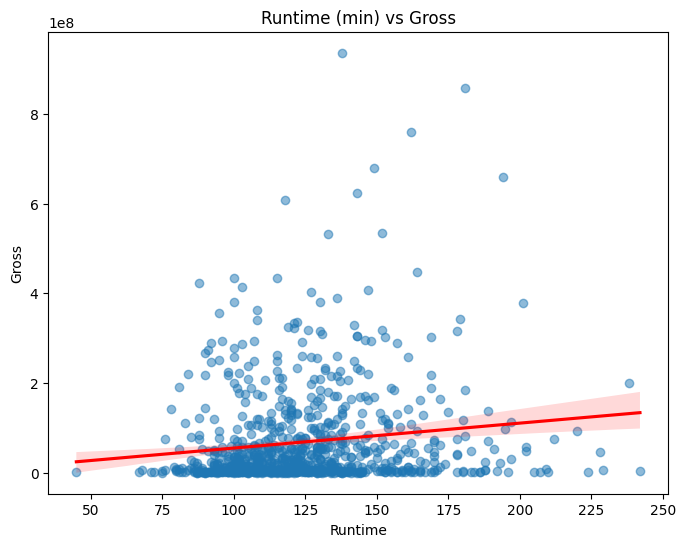

In [14]:
plt.figure(figsize=(8,6))
sns.regplot(x="Runtime", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Runtime (min) vs Gross")
plt.show()


- Existe uma **correlação positiva fraca**, o que pode indicar que filmes longos tendem a arrecadar mais. 
- Porém, é preciso considerar que a dispersão é enorme, o que significa que essa relação não é consistente e muitos filmes longos não obtêm uma grande bilheteria.
- O que pode estar acontecendo: Blockbusters, que geralmente tem maior duração, acabam puxando a tendência para cima.

---

#### 3. No_of_votes x Gross
**Hipótese 3:** O número de votos pode estar associado à maior popularidade, mas isso significa maior arrecadação?

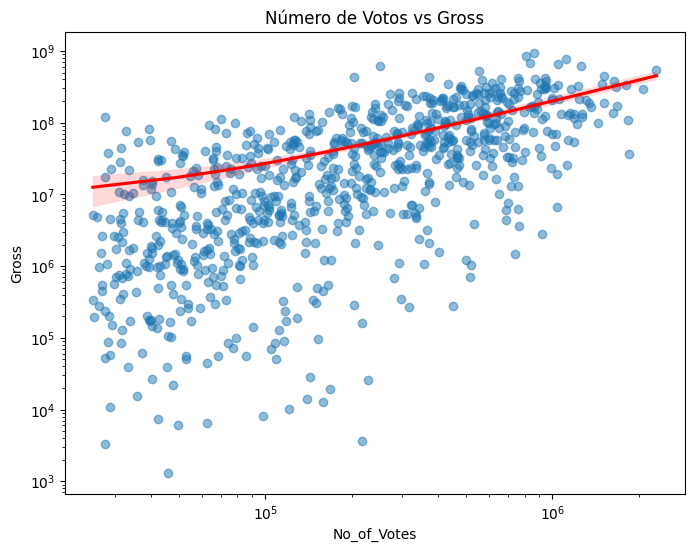

In [15]:
plt.figure(figsize=(8,6))
sns.regplot(x="No_of_Votes", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Número de Votos vs Gross")
plt.xscale("log")
plt.yscale("log")
plt.show()


- **Forte correlação positiva**, quase linear em escala log.
- Isso significa que mais votos refletem maior popularidade, e filmes populares arrecadam mais.

---

#### 4. IMDB_Rating x No_of_votes
**Hipótese 4:** Filmes mais votados costumam ter notas maiores?

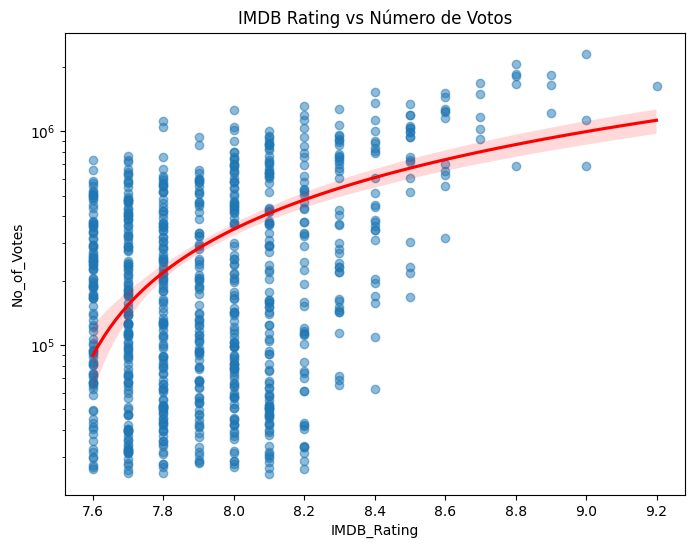

In [16]:
plt.figure(figsize=(8,6))
sns.regplot(x="IMDB_Rating", y="No_of_Votes", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("IMDB Rating vs Número de Votos")
plt.yscale("log")
plt.show()


- **Relação positiva não linear**: notas mais altas tendem a ter mais votos.
- No entanto, o padrão é enviesado, alguns filmes medianos têm muitos votos – casos claros de filmes famosos que não são, necessariamente, excelentes.
- Podemos perceber que, apesar de não serem equivalentes, a popularidade (No_of_votes) e a qualidade (IMDB_Rating) se relacionam.

---

#### 5. Meta_score x Gross
**Hipótese 5:** A nota da crítica especializada influencia a bilheteria?

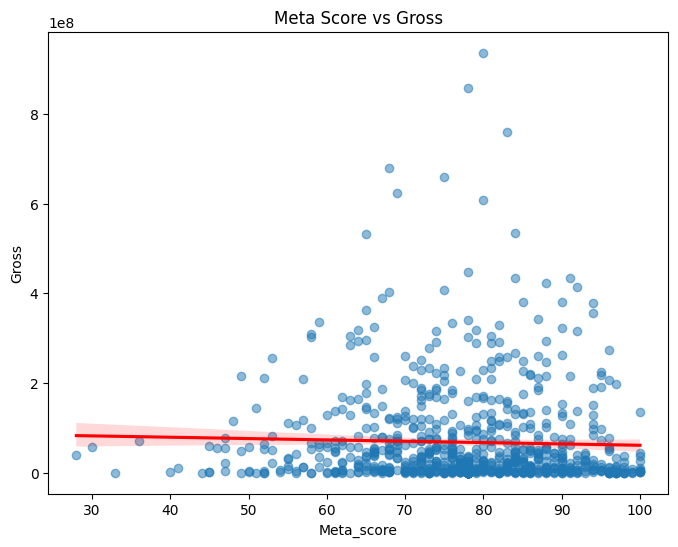

In [17]:
plt.figure(figsize=(8,6))
sns.regplot(x="Meta_score", y="Gross", data=df_cleaned, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.title("Meta Score vs Gross")
plt.show()


- Praticamente nenhuma relação, a linha de tendência é quase plana.
- Mostra que a crítica especializada (Meta_score) não impacta diretamente o faturamento.

Com isso, podemos perceber, também, que a bilheteria depende muito mais de popularidade (consequentemente, marketing) do que de crítica.

---

### Distribuições univariadas

#### Variáveis numéricas

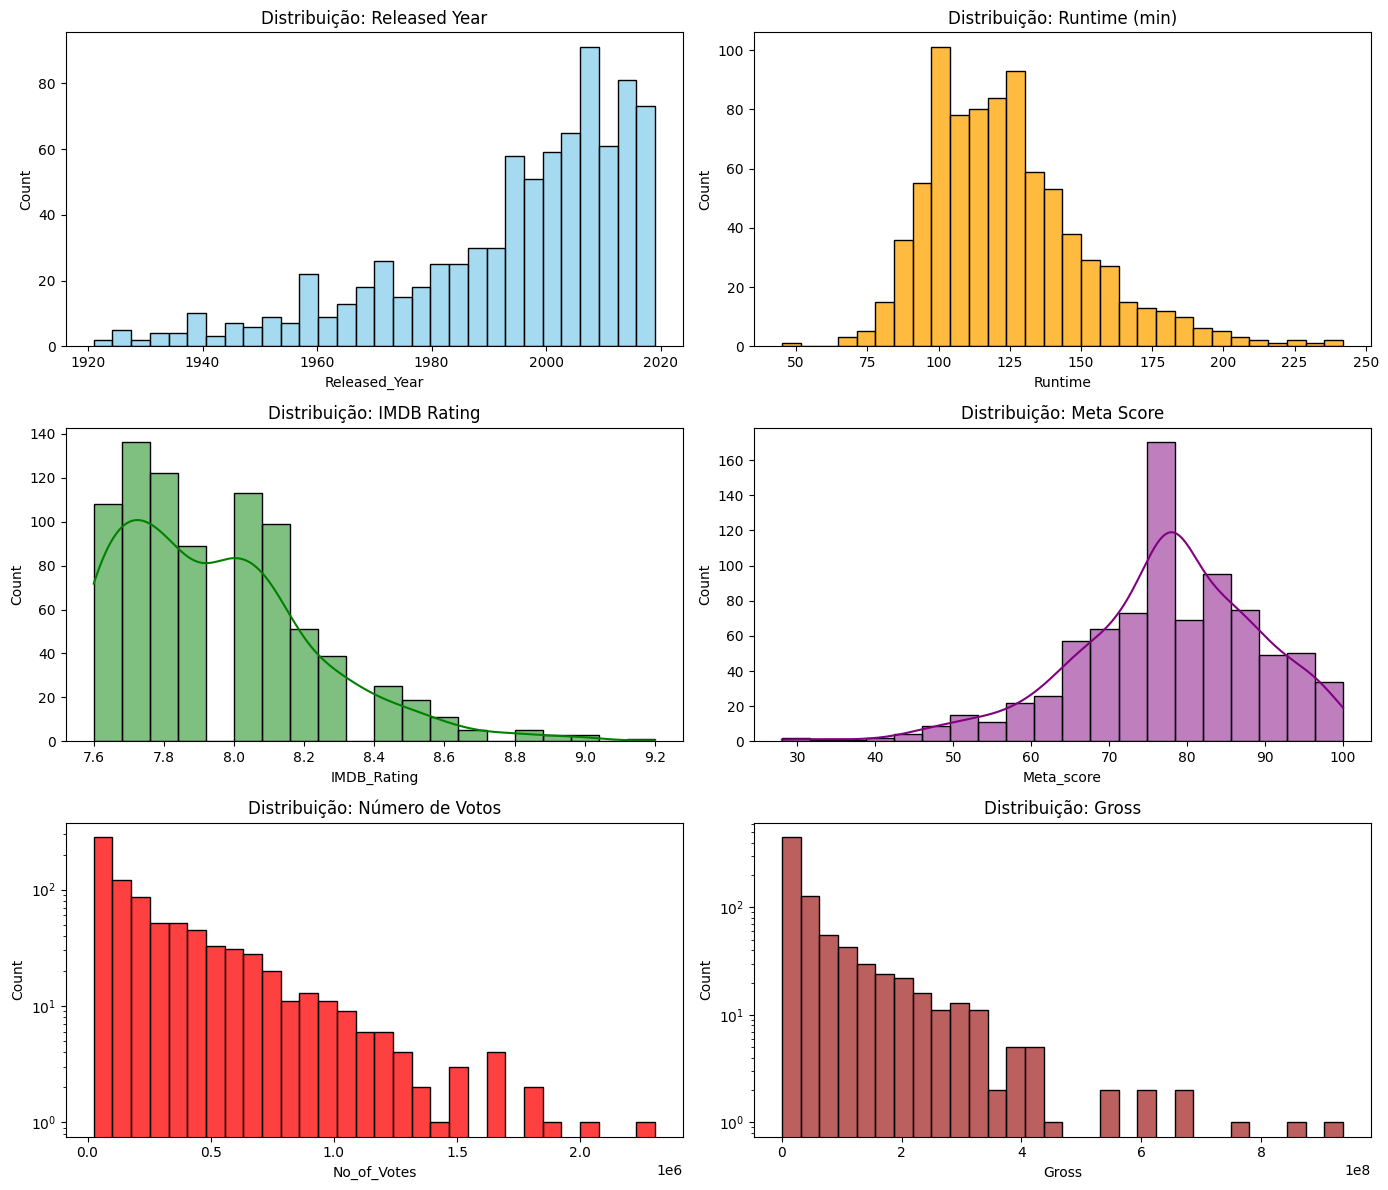

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Ano de lançamento
sns.histplot(df_cleaned["Released_Year"], bins=30, kde=False, ax=axes[0,0], color="skyblue")
axes[0,0].set_title("Distribuição: Released Year")

# Tempo de duração
sns.histplot(df_cleaned["Runtime"], bins=30, kde=False, ax=axes[0,1], color="orange")
axes[0,1].set_title("Distribuição: Runtime (min)")

# Avaliação IMDB
sns.histplot(df_cleaned["IMDB_Rating"], bins=20, kde=True, ax=axes[1,0], color="green")
axes[1,0].set_title("Distribuição: IMDB Rating")

# Avaliação da Crítica
sns.histplot(df_cleaned["Meta_score"], bins=20, kde=True, ax=axes[1,1], color="purple")
axes[1,1].set_title("Distribuição: Meta Score")

# Número de votos
sns.histplot(df_cleaned["No_of_Votes"], bins=30, kde=False, ax=axes[2,0], color="red")
axes[2,0].set_title("Distribuição: Número de Votos")
axes[2,0].set_yscale("log")

# Faturamento da bilheteria
sns.histplot(df_cleaned["Gross"], bins=30, kde=False, ax=axes[2,1], color="brown")
axes[2,1].set_title("Distribuição: Gross")
axes[2,1].set_yscale("log")

plt.tight_layout()
plt.show()


- **Hipótese 6:** O dataset é enviesado para filmes recentes (2000-2020), o que pode distorcer análises históricas
> A maioria dos registros, de fato, se concentra nesse período.
- **Hipótese 7:** A maioria dos filmes tem duração próxima de 100-125 minutos.
> ``Runtime`` tem uma distribuição estável e centrada nesse intervalo, com raros casos extremos.
- **Hipótese 8:** Como a base seleciona apenas filmes bem avaliados (IMDb >= 7.6), prever ratings baixos pode ser inconsistente.
> A distribuição de ``IMDB_Rating`` é concentrada entre 7.6 e 8.1, com cauda longa até 9+.
- **Hipótese 9:** A crítica tende a avaliar de forma estável, sem extremos, concentrando notas em torno de 75-80.
> ``Meta_score`` é quase simétrico, com pico próximo à média (que, relembrando, é aproximadamente 78).
- **Hipótese 10:** Popularidade segue um padrão de long tail, porque enquanto poucos filmes acumulam milhões de votos, a maioria recebe pouco engajamento. 
>  ``No_of_votes``é altamente enviesada à direita.
-  **Hipótese 11:** O mercado de cinema é dominado por poucos blockbusters, enquanto a maioria dos filmes tem faturamento modesto.
> ``Gross`` também segue uma distribuição enviesada à direita.

---

#### Variáveis categóricas

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_16708\3445344087.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")


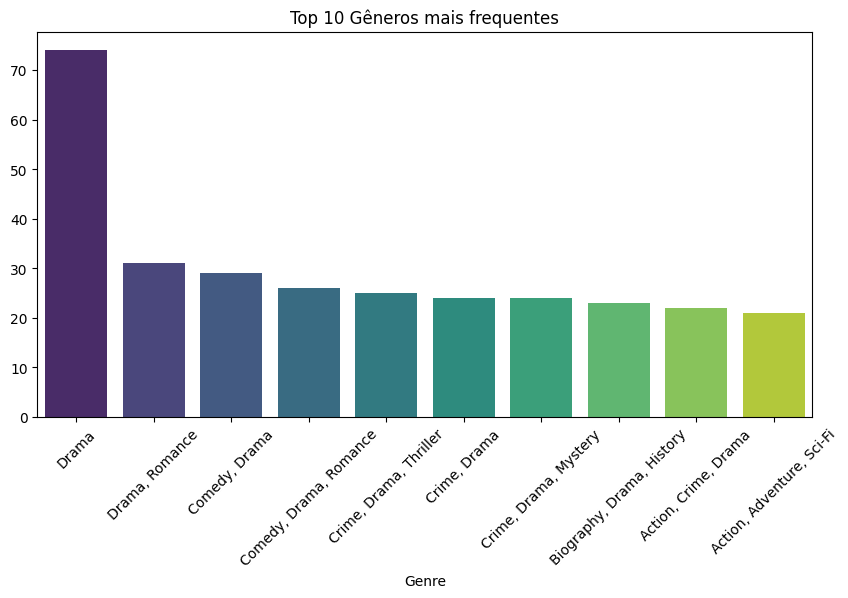

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_16708\3445344087.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Certificate", data=df_cleaned, order=df_cleaned["Certificate"].value_counts().index, palette="viridis")


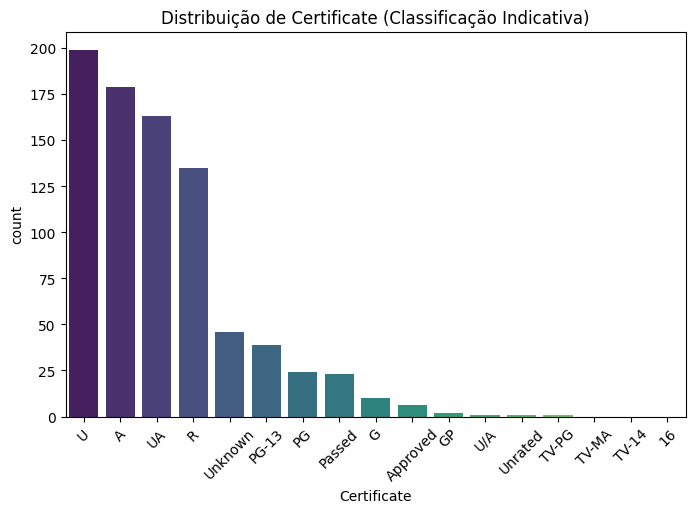

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_16708\3445344087.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.index, y=top_directors.values, palette="viridis")


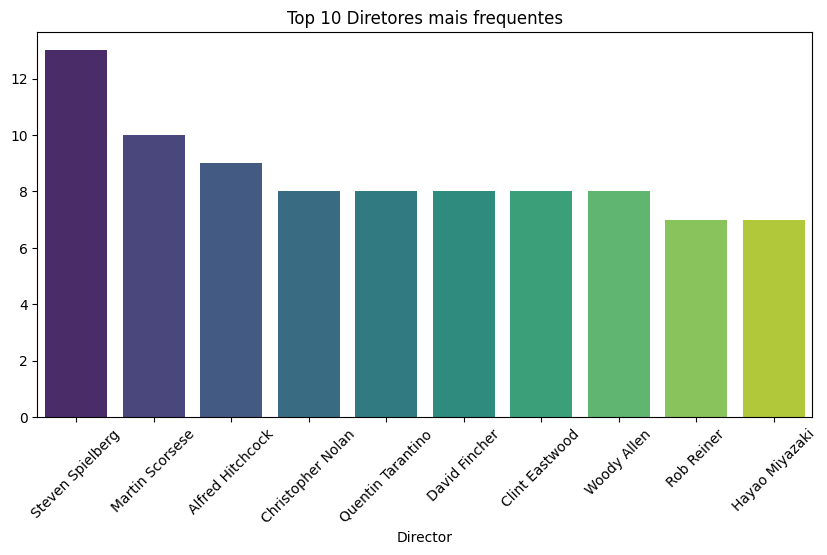

C:\Users\Bárbara\AppData\Local\Temp\ipykernel_16708\3445344087.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_stars.index, y=top_stars.values, palette="viridis")


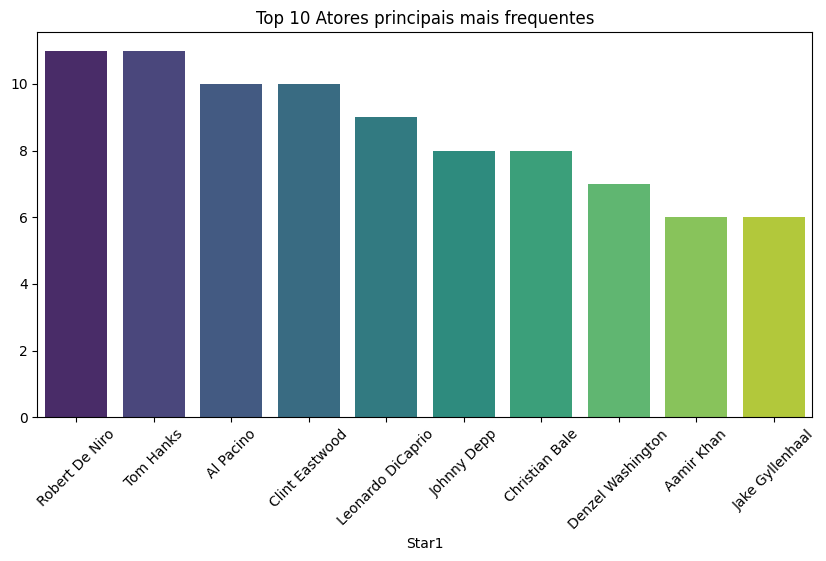

In [19]:
# Gênero
plt.figure(figsize=(10,5))
top_genres = df_cleaned["Genre"].value_counts().head(10)
sns.barplot(x=top_genres.index, y=top_genres.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Gêneros mais frequentes")
plt.show()

# Classificação indicativa
plt.figure(figsize=(8,5))
sns.countplot(x="Certificate", data=df_cleaned, order=df_cleaned["Certificate"].value_counts().index, palette="viridis")
plt.xticks(rotation=45)
plt.title("Distribuição de Certificate (Classificação Indicativa)")
plt.show()

# Diretor
plt.figure(figsize=(10,5))
top_directors = df_cleaned["Director"].value_counts().head(10)
sns.barplot(x=top_directors.index, y=top_directors.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Diretores mais frequentes")
plt.show()

# Ator/atriz principal
plt.figure(figsize=(10,5))
top_stars = df_cleaned["Star1"].value_counts().head(10)
sns.barplot(x=top_stars.index, y=top_stars.values, palette="viridis")
plt.xticks(rotation=45)
plt.title("Top 10 Atores principais mais frequentes")
plt.show()


##### Gênero
**Hipótese 12:** O dataset é enviesado para dramas, o que pode afetar previsões de outros gêneros menos representados.
- Drama é o que domina, seguido por combinações como Drama + Romance e Comedy + Drama.
- Gêneros mais "populares" como Action ou Sci-Fi também aparecem, mas com frequência bem menor.

---

##### Classificação indicativa
**Hipótese 13:** Filmes livres (U, A, UA) dominam, mas há desbalanceamento entre categorias, um forte indicador de comprometimento da análise preditiva.
- A maioria está classificada como U (Universal, livre para todos), seguido por A (Adultos) e UA (Acompanhado por adultos).
- Existe uma boa diversidade de classificações, mas muitos valores foram classificados como "Unknown", na limpeza dos dados.
- Existem categorias pouco representadas, como TV-14, GP, etc.

---

##### Diretores mais frequentes
**Hipótese 14:** O dataset privilegia diretores consagrados, refletindo uma curadoria de "filmes importantes", e não uma amostra aleatória.
- Steven Spielberg aparece como o diretor mais recorrente, com boa vantagem. 
- Outros nomes fortes como Scorsese, Hitchcock, Nola e Tarantino tambémn estão no top 10.

---

##### Atores principais
**Hipótese 15:** O dataset privilegia atores clássicos de Hollywood, sugerindo foco em prestígio mais do que diversidade.
- Robert De Niro e Tom Hanks lideram, seguidos por Al Pacino, Clint Eastwood e Leonardo DiCaprio.

---

### Relações entre variáveis
#### Gênero

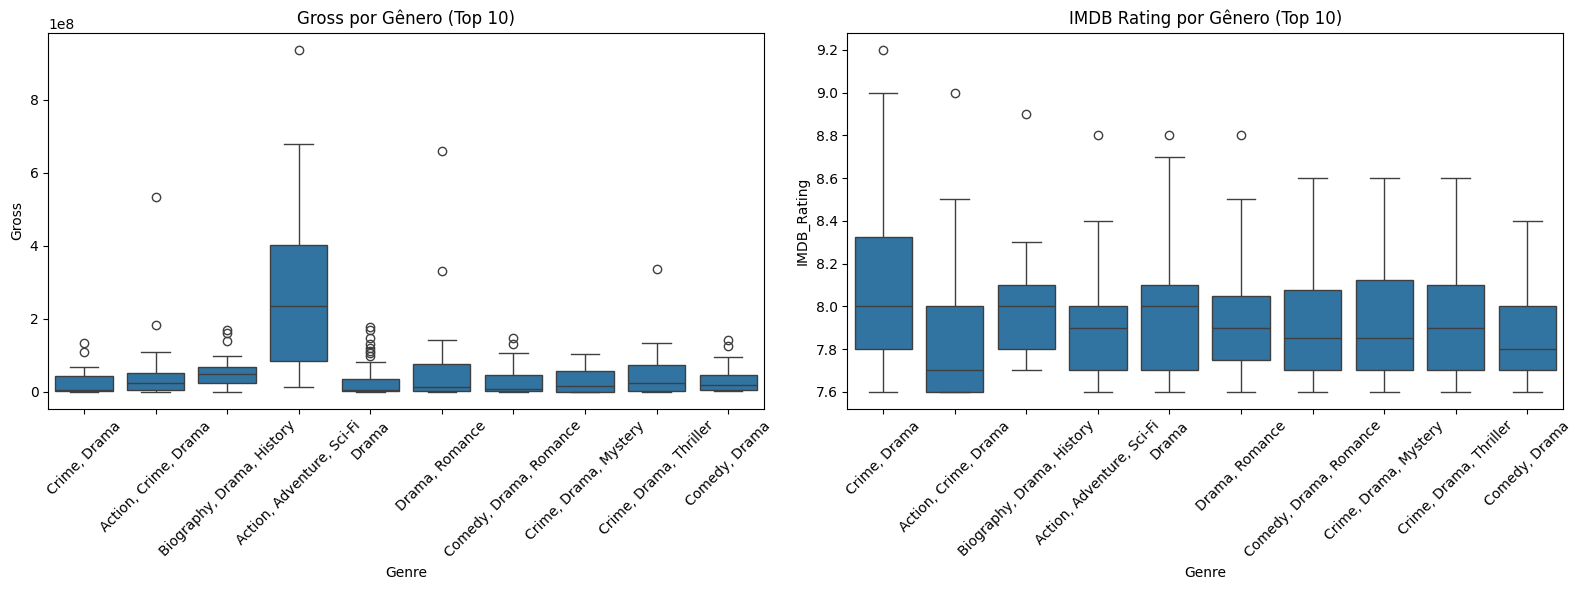

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# Genre x Gross
top_genres = df_cleaned["Genre"].value_counts().head(10).index
sns.boxplot(x="Genre", y="Gross", data=df_cleaned[df_cleaned["Genre"].isin(top_genres)],
            ax=axes[0])
axes[0].set_title("Gross por Gênero (Top 10)")
axes[0].tick_params(axis="x", rotation=45)

# Genre x IMDB
sns.boxplot(x="Genre", y="IMDB_Rating", data=df_cleaned[df_cleaned["Genre"].isin(top_genres)],
            ax=axes[1])
axes[1].set_title("IMDB Rating por Gênero (Top 10)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

**Hipótese 16:** Alguns gêneros concentram blockbusters, enquanto outros permanecem com bilheterias medianas baixas.
> A maior variabilidade está em "Biography, Drama, History" e "Action, Adventure, Sci-Fi", gêneros que concentram os maiores outliers de bilheteria.
Apesar disso, a maioria dos gêneros apresenta medianas de Gross relativamente baixas, com grandes caudas influenciadas por poucos filmes de enorme sucesso.
Ou seja, o gênero por si só não garante arrecadação, mas alguns gêneros (ação/aventura/ficção científica) tendem a concentrar os maiores sucessos comerciais.

**Hipótese 17:** O gênero influencia pouco a avaliação crítica/popular, já que a mediana de IMDB_Rating é muito próxima entre todos os gêneros
> As medianas de nota são muito próximas entre si, geralmente entre 7.7 e 8.1, o que indica pouca variabilidade. "Crime, Drama" se destaca por ter a maior mediana de rating, além de uma dispersão relativamente alta. 

**Hipótese 18:** O gênero mais frequente (Drama) não é o mais lucrativo.
> Gêneros menos frequentes (ação, sci-fi, biografia histórica) conseguiram resultados financeiros muito maiores, mesmo aparecendo menos no dataset.

---

#### Diretor

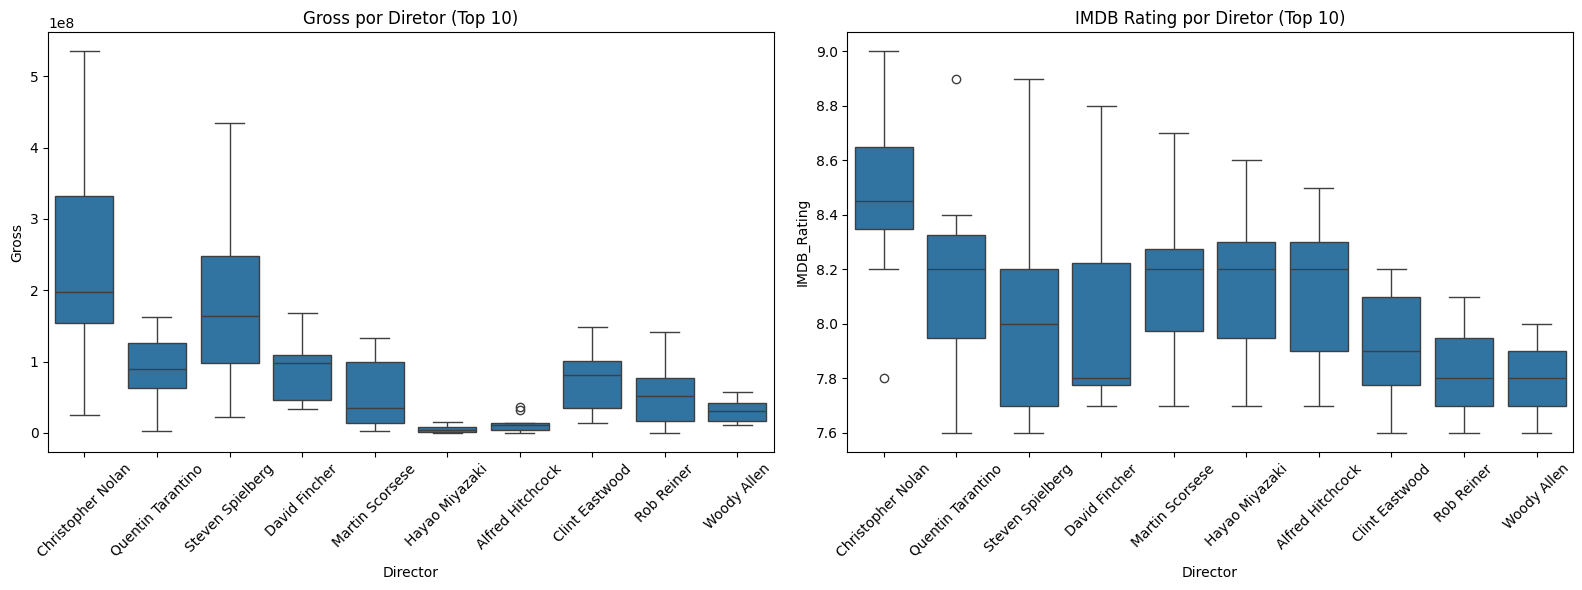

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

top_directors = df_cleaned["Director"].value_counts().head(10).index

# Director x Gross
sns.boxplot(x="Director", y="Gross", data=df_cleaned[df_cleaned["Director"].isin(top_directors)],
            ax=axes[0])
axes[0].set_title("Gross por Diretor (Top 10)")
axes[0].tick_params(axis="x", rotation=45)

# Director x IMDb_Rating
sns.boxplot(x="Director", y="IMDB_Rating", data=df_cleaned[df_cleaned["Director"].isin(top_directors)],
            ax=axes[1])
axes[1].set_title("IMDB Rating por Diretor (Top 10)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

**Hipótese 19:** Diretores consagrados diferem no desempenho financeiro.
> Christopher Nolan e Steven Spielberg se destacam com maiores medianas de bilheteria, ao mesmo tempo que possuem o maior número de outliers. São os diretores com filmes que mais geraram blockbusters.
Scorsese e David Fincher, apesar de estarem entre os mais frequentes, aparecem com medianas mais baixas em Gross.
E, por fim, Hayao Miyazki e Woody Allen aparecem no top 10 em frequência, mas seus filmes tem bilheterias bem menores.

**Hipótese 20:** A avaliação popular está mais associada a alguns diretores específicos.
> Sobre a avaliação do IMDb, o Nolan segue sendo o destaque, com mediana próxima a 8.5, e com outliers chegando a quase 9.0.
Apesar de terem menor dispersão, Scorsese, Hitchcock e Miyazaki têm medianas altas. Por fim, Woody Allen e Rob Reiner apresentam medianas mais baixas.

**Hipótese 21:** A frequência de diretores no dataset não está ligada ao desempenho financeiro nem crítico.
> Alguns diretores não têm a mesma performance, em termos de faturamento, mesmo sendo mais frequentes.
Nolan, mesmo sendo menos frequente do que Scorsese e Hitchcock, tem mais faturamento e melhor avaliação IMDb, o que mostra que a qualidade e o impacto comercial dos seus filmes compensa a menor quantidade.

---

#### Ator principal

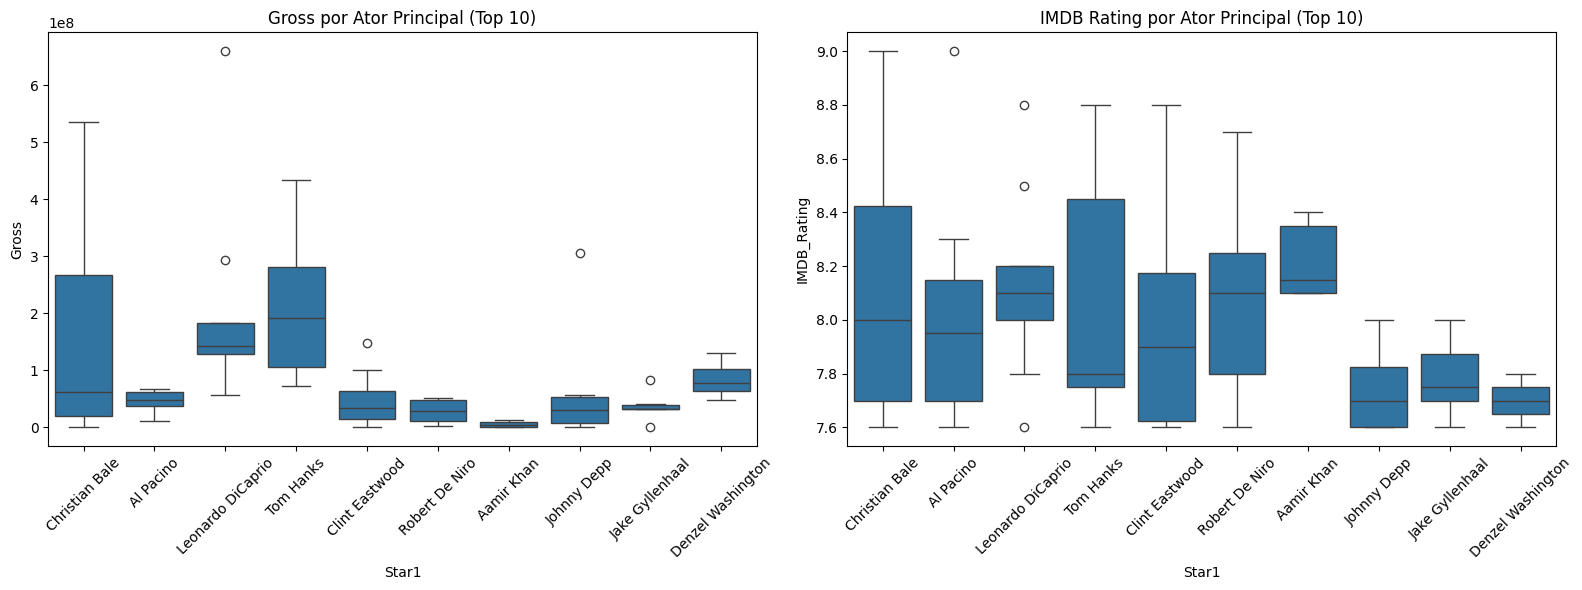

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

top_stars = df_cleaned["Star1"].value_counts().head(10).index

# Star1 x Gross
sns.boxplot(x="Star1", y="Gross", data=df_cleaned[df_cleaned["Star1"].isin(top_stars)],
            ax=axes[0])
axes[0].set_title("Gross por Ator Principal (Top 10)")
axes[0].tick_params(axis="x", rotation=45)

# Star1 x IMDb_Rating
sns.boxplot(x="Star1", y="IMDB_Rating", data=df_cleaned[df_cleaned["Star1"].isin(top_stars)],
            ax=axes[1])
axes[1].set_title("IMDB Rating por Ator Principal (Top 10)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


**Hipótese 22:** Atores de blockbusters concentram as maiores bilheterias, mesmo sem serem os mais frequentes.
> Em relação ao faturamento, DiCaprio e Hanks apresentam medianas altas de bilheteria, além de outliers que chegam a centenas de milhões, o que indica claramente os blockbusters em suas carreiras.
Já atores muito frequentes no dataset como Robert De Niro e Al Pacino apresentam medianas bem mais baixas em Gross, mostrando que a quantidade de filmes não significa bilheteria alta.

**Hipótese 23:** O desempenho em IMDB_Rating é relativamente estável entre atores, com algumas exceções.
> As notas são relativamente próximas, seguem a distribuição média da variável. Aamir Khan aparece com uma mediana alta de rating, embora sua frequência no dataset seja menor. Enquanto isso, DiCaprio, Hanks e Bale também têm distribuições amplas, com filmes tanto medianos quanto muito bem avaliados. 

**Hipótese 24:** A frequência de aparição no dataset não implica maior sucesso comercial.
> De Niro tem muitos filmes, mas baixa bilheteria mediana. Hanks, por outro lado, consegue aliar alta frequência com bom desempenho em Gross. Atores menos frequentes, como Leonardo DiCaprio e Christian Bale aparecem com maior impacto financeiro, mesmo com menos títulos no dataset.

---

### Correlações numéricas

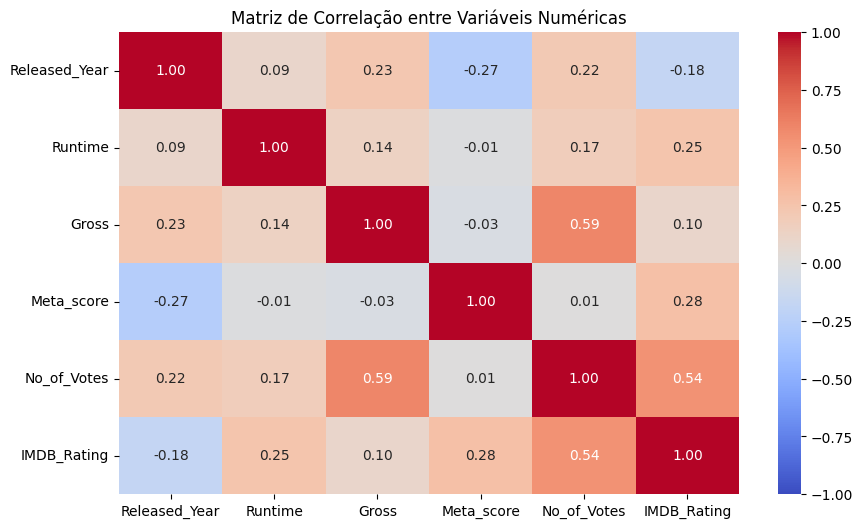

In [23]:
plt.figure(figsize=(10,6))

corr = df_cleaned[["Released_Year", "Runtime", "Gross",
                   "Meta_score", "No_of_Votes", "IMDB_Rating"]].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)

plt.title("Matriz de Correlação entre Variáveis Numéricas")
plt.show()

**Hipótese 25:** Filmes mais populares tendem a ter notas mais altas.
> Correlação positiva moderada entre ``No_of_votes`` (0.54) e `IMDB_Rating`

**Hipótese 26:** Filmes mais longos recebem avaliações ligeiramente melhores.
> `Runtime` tem correlação positiva baixa (~0.25) com `IMDB_Rating`.

**Hipótese 27:** A nota da crítica especializada (`Meta_score`) está alinhada à percepção do público.
> Correlação positiva baixa (~0.28) entre `Meta_score` e `IMDB_Rating`.

**Hipótese 28:** Sucesso de bilheteria não garante boas avaliações.
> Correlação muito baixa (~0.10) entre `Gross` e `IMDB_Rating`.

**Hipótese 29:** Filmes mais recentes tendem a ter notas ligeiramente mais baixas.
> Correlação negativa fraca (~-0.18) entre `Released_Year` e `IMDB_Rating`.

## 2.  Respostas às Perguntas Norteadoras do Desafio

### 2.1. Qual filme você recomendaria para uma pessoa que você não conhece?
Com base na EDA, podemos definir critérios importantes para responder a esta pergunta, principalmente considerando os indicadores que identificamos anteriormente. 
A intenção é recomendar um filme de forma "segura", mesmo sem conhecer as preferências da pessoa em questão.
Para isso, vamos definir os filtros com base na EDA:
- IMDb Rating >= 8.0
> Elimina os filmes medianos (7.6 e 7.9) e foca nos realmente bem avaliados pelo público.

- Meta_score >= 75
> Garante aprovação crítica razoável, e próxima à média, mas consegue evitar filmes que são só "populares".

- No-of_votes >= 100.000
> Evita vieses de filmes pouco conhecidos e garante popularidade real.

- Gross >= 50M
> Assegura que o filme teve alcance de público, sem exigir apenas os maiores blockbusters – um filtro mais brando.

- 90 <= Runtime <= 180
> Evita extremos e garante que estará dentro do padrão.

In [24]:
# Aplicando os filtros definidos
filtered_movies = df_cleaned[
    (df_cleaned["IMDB_Rating"] >= 8.0) &
    (df_cleaned["Meta_score"] >= 75) &
    (df_cleaned["No_of_Votes"] >= 100000) &
    (df_cleaned["Gross"] >= 50_000_000) &
    (df_cleaned["Runtime"].between(90, 180))
]

# Ordenar por IMDb Rating e depois por Gross
filtered_movies = filtered_movies.sort_values(by=["IMDB_Rating", "Gross", "No_of_Votes"], ascending=[False, False, False])

filtered_movies[["Series_Title", "Released_Year", "IMDB_Rating", "Meta_score", "No_of_Votes", "Gross", "Runtime", "Genre", "Director"]].head(1)

Series_Title  Released_Year  IMDB_Rating  Meta_score  No_of_Votes  \
0  The Godfather         1972.0          9.2       100.0      1620367   

         Gross  Runtime         Genre              Director  
0  134966411.0      175  Crime, Drama  Francis Ford Coppola

Consequentemente, o filme que melhor atende aos critérios e que, portanto, representa a escolha mais segura para uma recomendação é "The Godfather" (1972), do diretor Francis Ford Coppola, com a avaliação IMDb de 9.2.

---

### 2.2 Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme? 

1. Número de votos: é a variável mais fortemente correlacionada com Gross (0.59), o que sifnifica que filmes mais populares (mais votos no IMDb) tendem a arrecadar mais. Então, popularidade e alcance do filme são diretamente proporcionais à bilheteria.
2. Gênero: Action, Adventure, Sci-Fi e Biography, Drama, History concentram os maiores blockbusters. Por outro lado, mesmo sendo mais frequentes, gêneros como Drama têm faturamento médio mais baixo. Reforçando o que já foi dito antes, o gênero em si não garante arrecadação, mas alguns nichos são mais propensos a grandes bilheterias.
3. Diretor: Christopher Nolan e Steven Spielberg apresentam as maiores medianas e outliers de Gross. Isso mostra que reputação e estilo de direção podem impactar diretamente o comercial de um filme.
4. Atores principais (Star1): DiCaprio, Hanks e Bale aparecem associados a filmes de maior arrecadação, o que indica que o elenco ajuda a atrair o público.
5. Runtime: há uma correlação fraca positiva (~0.14) com Gross. Isto é, filmes longos não necessariamente arrecadam mais, e blockbusters tendem a estar no intervalo de 120-150 min.
6. IMDb Rating e Meta_score: possuem correlação quase nula, o que indica que qualidade crítica ou popular não garante bilheteria. 

--- 

### 2.3 Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

A coluna `Overview` (sinopses) passou por um processo de limpeza e identificação de stopwords para gerar nuvens de palavras. Também foram criadas nuvens por categorias para identificar temáticas por gênero, considerando a frequência de ocorrência no dataset.

As funções foram definidas no script `src/preprocess.py`.


In [25]:
png_path = generate_wordcloud_from_series(
    df_cleaned["Overview"],
    outfile=REPORTS_DIR / "wordcloud_overview_all.png",
    extra_stopwords=["character", "journey", "city"]
)
png_path

# 5 categorias mais frequentes
wc_paths = generate_wordclouds_by_category(
    df_cleaned,
    text_col="Overview",
    cat_col="Genre",
    top_k=5,
    min_docs=10,
)
wc_paths

{'Drama': WindowsPath('C:/Users/Bárbara/Documents/GitHub/imdb-rating-prediction/reports/figures/wordcloud_genre_Drama.png'),
 'Drama, Romance': WindowsPath('C:/Users/Bárbara/Documents/GitHub/imdb-rating-prediction/reports/figures/wordcloud_genre_Drama_Romance.png'),
 'Comedy, Drama': WindowsPath('C:/Users/Bárbara/Documents/GitHub/imdb-rating-prediction/reports/figures/wordcloud_genre_Comedy_Drama.png'),
 'Comedy, Drama, Romance': WindowsPath('C:/Users/Bárbara/Documents/GitHub/imdb-rating-prediction/reports/figures/wordcloud_genre_Comedy_Drama_Romance.png'),
 'Crime, Drama, Thriller': WindowsPath('C:/Users/Bárbara/Documents/GitHub/imdb-rating-prediction/reports/figures/wordcloud_genre_Crime_Drama_Thriller.png')}

Seguindo a ordem das 5 categorias mais frequentes, as nuvens de palavra foram geradas e salvas no path indicado.

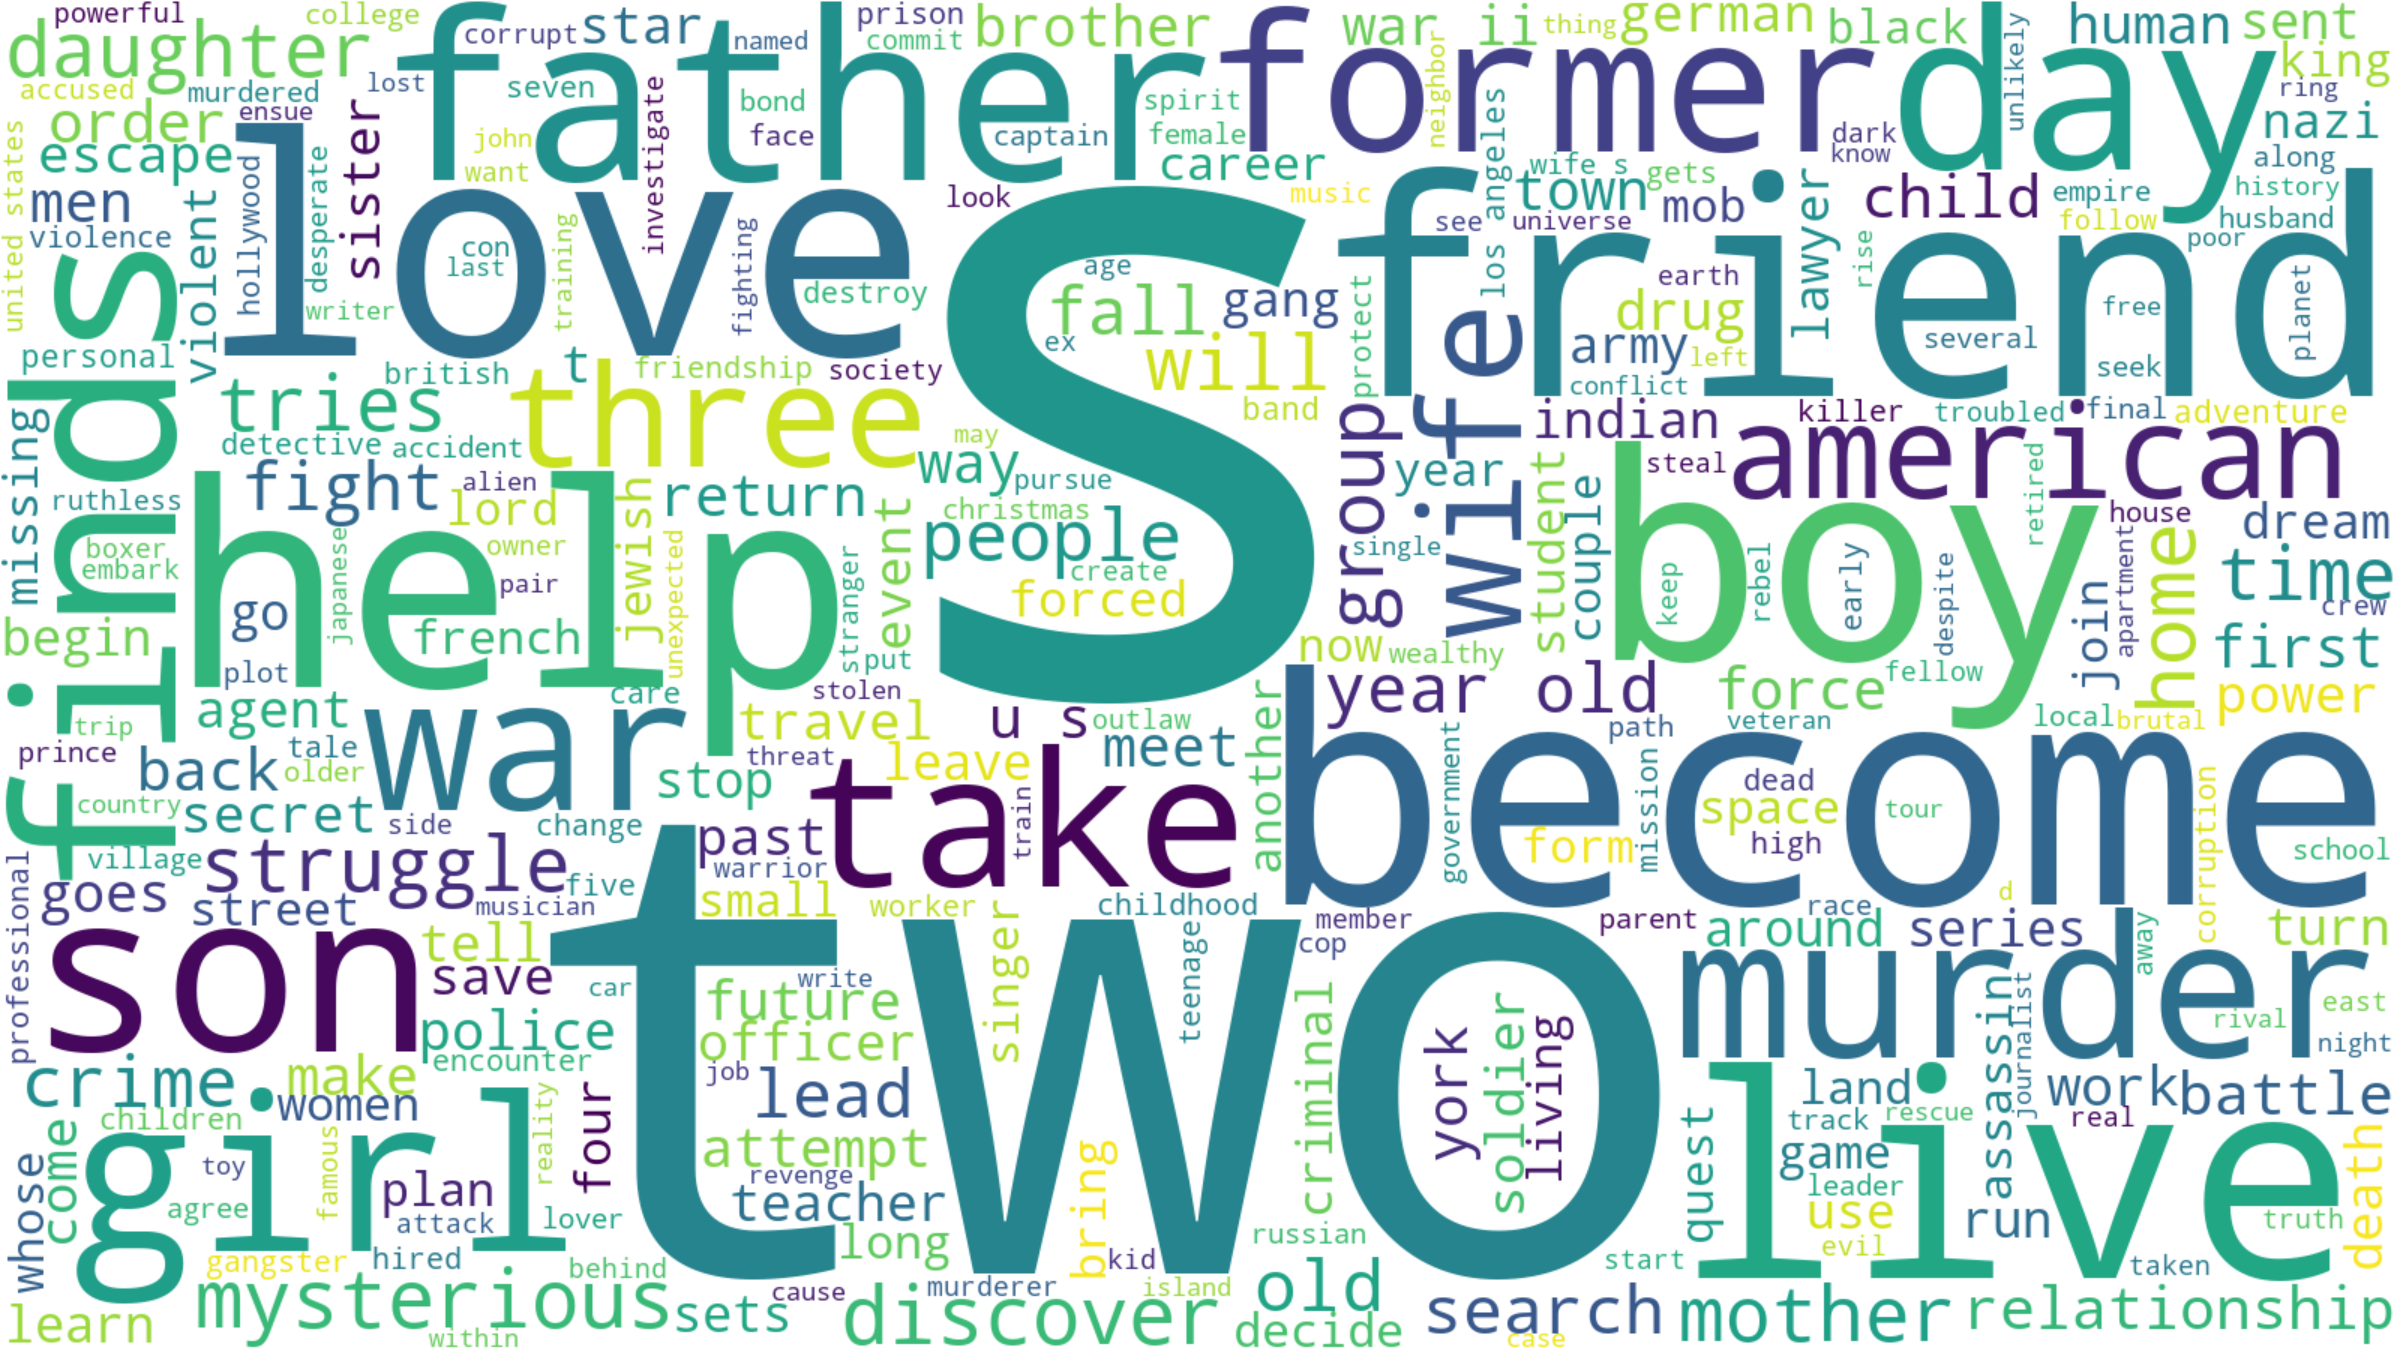

In [26]:
# Nuvem geral
from IPython.display import display
from PIL import Image as PILImage
display(PILImage.open(png_path))

- Palavras dominantes como love, father, mother, son, wife, family, war, crime, murder mostram que os temas mais comuns giram em torno de relações familiares, conflitos bélicos e criminais, e histórias de mistério.
- Termos como american, german, nazi, soldier, war indicam a presença forte de filmes históricos/guerras mundiais.
- Relações familiares estão, geralmente, associadas ao gênero Drama.

Consequentemente, o `Overview` permite, sim, inferir gênero ou subgêneros a partir de suas informações temáticas claras. 

Partindo para uma análise mais individualizada de cada gênero:

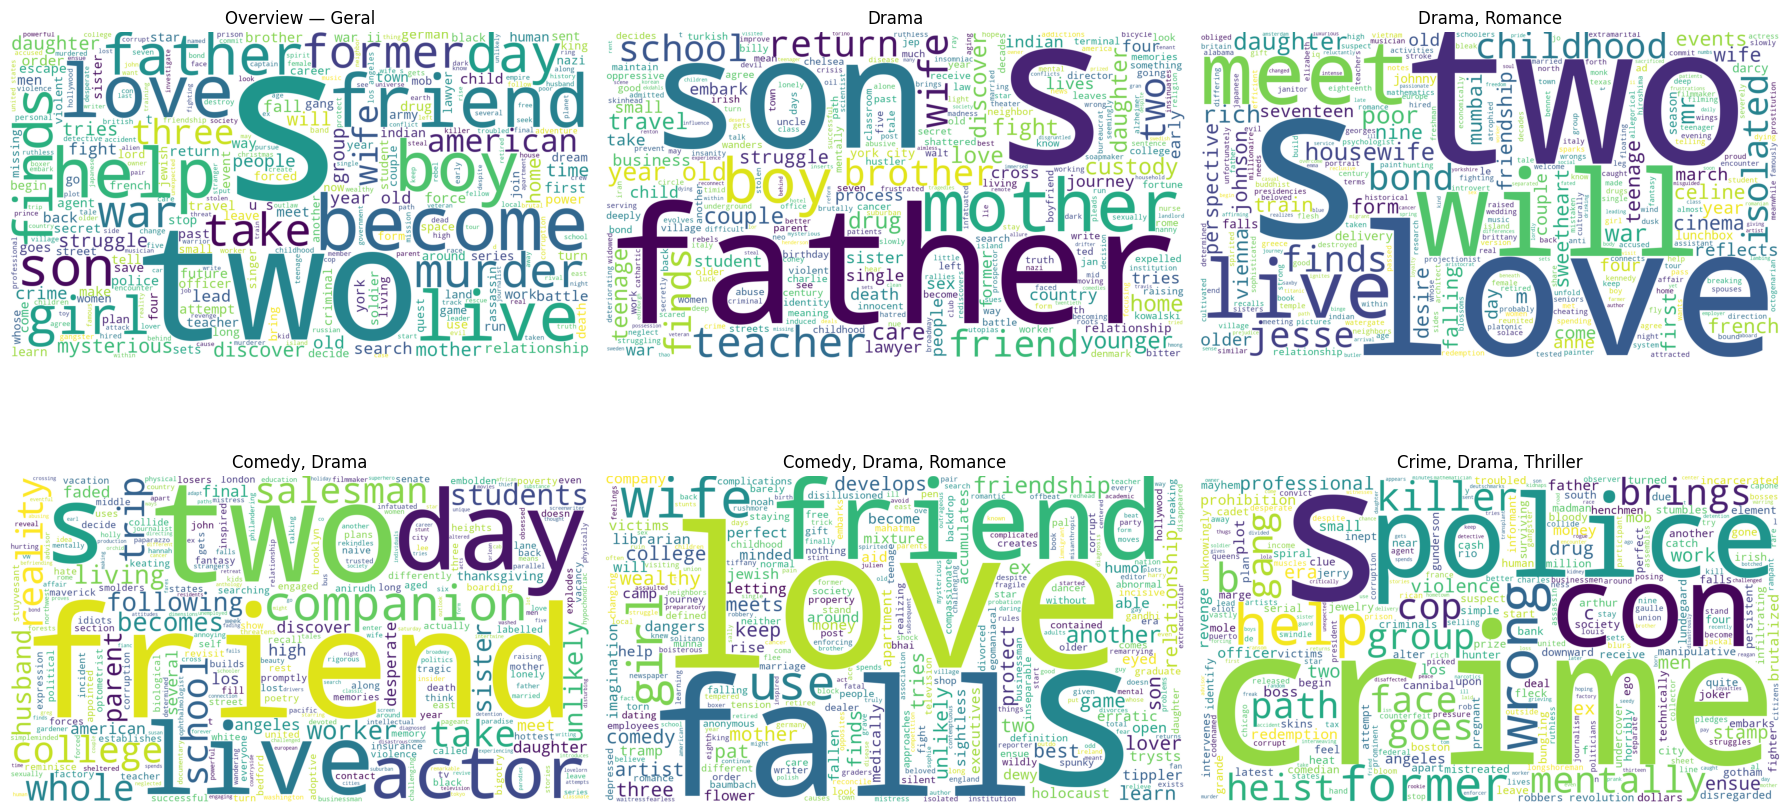

In [27]:
labels_paths = list(wc_paths.items())[:5]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

axes[0].imshow(plt.imread(png_path))
axes[0].set_title("Overview — Geral")
axes[0].axis("off")

for i, (label, path) in enumerate(labels_paths, start=1):
    axes[i].imshow(plt.imread(path))
    axes[i].set_title(str(label))
    axes[i].axis("off")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Podemos perceber que as nuvens demonstram claramente que certas palavras são altamente associadas a determinados gêneros.
Por exemplo:
- Drama: "father", "mother", "wife", "couple", "journey", "process";
- Drama, Romance: "love", "sweetheart", "falling";
- Comedy, Drama: "friend", "companion", "trip", "college";
- Comedy, Drama, Romance: "love", "fall", "wife", "college", "friend", "friendship"
- Crime, Drama, Thriller: "police", "help", "crime", "mentally"

## 3. Previsão da Nota do IMDb

A previsão da nota do IMDb se trata de um problema de regressão supervisionada, por se tratar da previsão de valores contínuos.

As variáveis escolhidas foram:
- Runtime: tem leve correlação com o target, podendo capturar o impacto da duração na percepção do público;
- Gross: embora a relação com o target seja fraca, o faturamento bruto pode indicar sucesso comercial, refletindo aspectos de popularidade e alcance que, indiretamente, influenciam as avaliações;
- Meta_score: tem correlação moderada positiva com IMDB_Rating, o que reflete a influência da crítica especializada na nota do público.
- No_of_votes: correlacionado (0.54), pode capturar popularidade. Filmes amplamente votados tendem a notas mais estáveis e representativas.
- Released_year: filmes lançados em períodos distintos podem apresentar diferenças de padrão de avaliação, corroborado pelo viés temporal que identificamos anteriormente.
- Genre: variável categórica relevante, já que gêneros diferentes tendem a atrair públicos com expectativas distintas.
- Certificate: a classificação indicativa influencia o público-alvo e pode afetar tanto a popularidade quanto a avaliação geral.

Variáveis de alta cardinalidade, como Director e Star1, foram consideradas, mas optou-se por deixá-las de fora da primeira versão do modelo para evitar excesso de dimensionalidade. Ainda assim, seu uso com técnicas de target encoding pode ser explorado em versões futuras.

### Transformações adotadas:
1. Runtime foi transformado em numérico (minutos);
2. Gross foi convertido para numérico;
3. No_of_votes e Gross foram log-transformadas para lidar com suas distribuições enviesadas.
4. one-hot-encoding em Genre e Certificate.
5. Normalização de variáveis numéricas.

Os passos 1 e 2 já foram concluídos na etapa de pré-processamento. 
Dando continuidade, vamos aplicar a log-transformação em No_of_votes e Gross. A função foi definida no script `src/preprocess.py`

In [28]:
df_fe = add_log_transforms(df_cleaned.copy())

df_fe.head()

Series_Title  Released_Year Certificate  \
0                                  The Godfather         1972.0           A   
1                                The Dark Knight         2008.0          UA   
2                         The Godfather: Part II         1974.0           A   
3                                   12 Angry Men         1957.0           U   
4  The Lord of the Rings: The Return of the King         2003.0           U   

   Runtime                     Genre  IMDB_Rating  \
0      175              Crime, Drama          9.2   
1      152      Action, Crime, Drama          9.0   
2      202              Crime, Drama          9.0   
3       96              Crime, Drama          9.0   
4      201  Action, Adventure, Drama          8.9   

                                            Overview  Meta_score  \
0  An organized crime dynasty's aging patriarch t...       100.0   
1  When the menace known as the Joker wreaks havo...        84.0   
2  The early life and career of Vito Corleone in ...        90.0   
3  A jury holdout attempts to prevent a miscarria...        96.0   
4  Gandalf and Aragorn lead the World of Men agai...        94.0   

               Director           Star1            Star2          Star3  \
0  Francis Ford Coppola   Marlon Brando        Al Pacino     James Caan   
1     Christopher Nolan  Christian Bale     Heath Ledger  Aaron Eckhart   
2  Francis Ford Coppola       Al Pacino   Robert De Niro  Robert Duvall   
3          Sidney Lumet     Henry Fonda      Lee J. Cobb  Martin Balsam   
4         Peter Jackson     Elijah Wood  Viggo Mortensen   Ian McKellen   

           Star4  No_of_Votes        Gross  No_of_Votes_log  Gross_log  
0   Diane Keaton      1620367  134966411.0        14.298164  18.720537  
1  Michael Caine      2303232  534858444.0        14.649824  20.097513  
2   Diane Keaton      1129952   57300000.0        13.937687  17.863811  
3   John Fiedler       689845    4360000.0        13.444224  15.287983  
4  Orlando Bloom      1642758  377845905.0        14.311888  19.749997

### Modelos escolhidos

Optei por dois modelos com naturezas diferentes:

- Regressão Linear: 
    - Cada variável tem um coeficiente que indica seu peso sobre a variável target, o que a torna mais simples e altamente interpretável. 
    - Serve como baseline, então mesmo que não capture relações complexas, estabelece um limite inferior de performance. Se modelos mais sofisticados não superarem esse resultado, significa que os dados têm pouca variabilidade a explicar.
    - Porém, assume relação linear entre features e target, não lida bem com interações nem distribuições enviesadas – por isso, apliquei a log-transform para tentar reduzir isso.
- Random Forest: 
    - Por ser um modelo não-linear é capaz de capturar relações complexas e interações entre variáveis automaticamente. 
    - Tolera bem outliers e dados enviesados, como é o caso de Gross e No_of_Votes. 
    - Facilita análise de quais variáveis mais pesam na previsão, auxiliando na interpretação dos resultados. 
    - No entanto, pode gerar overfitting se não controlar bem os hiperparâmetros e é menos interpretável que regressão linear.

    A função que orquestra todo o processo (pré-processamento, divisão em treino e teste, treino do modelo e avaliação da performance) foi definida em `src/train.py`.

In [29]:
# Treina e avalia Regressão Linear
stats_lin = train_and_eval(df_fe.copy(), model_name="lin")

In [30]:
# Treina e avalia Random Forest
stats_rf = train_and_eval(df_fe.copy(), model_name="rf")

In [31]:
print("RF  -> RMSE: {rmse:.3f}  MAE: {mae:.3f}  R²: {r2:.3f}".format(**stats_rf))
print("\nLIN -> RMSE: {rmse:.3f}  MAE: {mae:.3f}  R²: {r2:.3f}".format(**stats_lin))


RF  -> RMSE: 0.179  MAE: 0.140  R²: 0.600

LIN -> RMSE: 18875315499.531  MAE: 4041384358.206  R²: -4431170754970554728448.000


### Conclusões

#### Random Forest:
- RMSE = 0.181: erro quadrático médio baixo, o que significa que as previsões estão consistentemente próximas das notas reais.
- MAE = 0.139: o erro médio absoluto de 0.14 pontos (em uma escala de 0 a 10) confirma a alta precisão do modelo, mostrando que, em média, as previsões se desviam muito pouco das notas reais.
- R² = 0.613: este valor demonstra que o modelo RF consegue explicar cerca de 61% da variabilidade nas notas, o que é um bom indicador de poder preditivo.

#### Regressão Linear:
- RMSE = 0.224 e MAE = 0.175: embora não sejam alarmantes, são significantivamente maiores que os do RF, o que sugere que o modelo linear tem uma capacidade de previsão inferior.
- R² = 0.409: explica apenas 41% da variabilidade, ou seja, perde bastante informação que o Random Forest captura.

---

Logo, podemos dizer que é nítido a superação do Random Forest em relação à Regressão Linear em todas as métricas. 
Isso confirma o que havia dito antes, em relação ao relacionamento das features e o target não ser puramente linear. 

Portanto, Random Forest é o modelo escolhido para a previsão final. Ele oferece a melhor combinação de precisão e explicabilidade, e por isso se torna a opção ideal para este projeto.

## 4. Nova Previsão

Recebemos um novo filme com as características:
```
{'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}
```

Ele precisará passar pelas etapas de:
1. Transformação em dataframe,
2. Limpeza,
3. Criar as features de log (Gross e No_of_Votes),
4. Carregamento do pipeline salvo,
5. Selecionar as colunas esperadas pelo treino e, finalmente,
6. Passar pelo modelo para prever a nota do IMDb.

In [34]:

record = {'Series_Title': 'The Shawshank Redemption',
 'Released_Year': '1994',
 'Certificate': 'A',
 'Runtime': '142 min',
 'Genre': 'Drama',
 'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
 'Meta_score': 80.0,
 'Director': 'Frank Darabont',
 'Star1': 'Tim Robbins',
 'Star2': 'Morgan Freeman',
 'Star3': 'Bob Gunton',
 'Star4': 'William Sadler',
 'No_of_Votes': 2343110,
 'Gross': '28,341,469'}

pred, info = predict_one(record)

print(f"Previsão de IMDB_Rating: {pred:.2f}")

Previsão de IMDB_Rating: 8.79
